In [ ]:
import os 
import datetime 
#打印时间 
def printbar():    
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')    
    print("\n"+"=========="*8 + "%s"%nowtime) 
    #mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量 
    os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

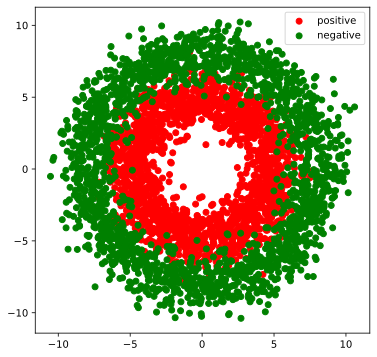

In [25]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"])

In [26]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = torch.LongTensor(indices[i: min(i + batch_size, num_examples)])
        yield  features.index_select(0, indexs), labels.index_select(0, indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tensor([[ 7.3950,  4.1624],
        [-7.4060,  4.1539],
        [ 4.9762,  1.6946],
        [ 4.3140, -1.5399],
        [ 1.5466,  6.2206],
        [ 6.8439,  4.3531],
        [ 5.0323, -2.7226],
        [-4.1810, -6.1000]])
tensor([[0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])


In [27]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2,4))
        self.b1 = nn.Parameter(torch.zeros(1,4))
        self.w2 = nn.Parameter(torch.randn(4,8))
        self.b2 = nn.Parameter(torch.zeros(1,8))
        self.w3 = nn.Parameter(torch.randn(8,1))
        self.b3 = nn.Parameter(torch.zeros(1,1))

    # 正向传播
    def forward(self,x):
        x = torch.relu(x@self.w1 + self.b1)
        x = torch.relu(x@self.w2 + self.b2)
        y = torch.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    def loss_func(self,y_pred,y_true):  
        #将预测值限制在1e-7以上, 1- (1e-7)以下，避免log(0)错误
        eps = 1e-7
        y_pred = torch.clamp(y_pred,eps,1.0-eps)
        bce = - y_true*torch.log(y_pred) - (1-y_true)*torch.log(1-y_pred)
        return torch.mean(bce)
    
    # 评估指标(准确率)
    def metric_func(self,y_pred,y_true):
        y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                          torch.zeros_like(y_pred,dtype = torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
    
model = DNNModel()

In [28]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

print("init loss:", loss.item())
print("init metric:", metric.item())

init loss: 9.941256523132324
init metric: 0.37969154119491577


In [29]:
len(list(model.parameters()))

6

In [30]:
def train_step(model, features, labels):   
    
    # 正向传播求损失
    predictions = model.forward(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
        
    # 反向传播求梯度
    loss.backward()
    
    # 梯度下降法更新参数
    for param in model.parameters():
        #注意是对param.data进行重新赋值,避免此处操作引起梯度记录
        param.data = (param.data - 0.01*param.grad.data) 
        
    # 梯度清零
    model.zero_grad()
        
    return loss.item(),metric.item()
 

def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in data_iter(X,Y,20):
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%100==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)
        
train_model(model,epochs = 1000)


================================================================================2021-09-27 10:38:36
epoch = 100 loss =  0.1719571564719081 metric =  0.9309999924898148

================================================================================2021-09-27 10:38:46
epoch = 200 loss =  0.1666175213549286 metric =  0.9349999922513962

================================================================================2021-09-27 10:38:56
epoch = 300 loss =  0.16571517213247716 metric =  0.9349999922513962

================================================================================2021-09-27 10:39:05
epoch = 400 loss =  0.16462765510659666 metric =  0.9357499924302101

================================================================================2021-09-27 10:39:15
epoch = 500 loss =  0.1645994845032692 metric =  0.9352499929070472

================================================================================2021-09-27 10:39:24
epoch = 600 loss =  0.16343970860354604 metric =  0.

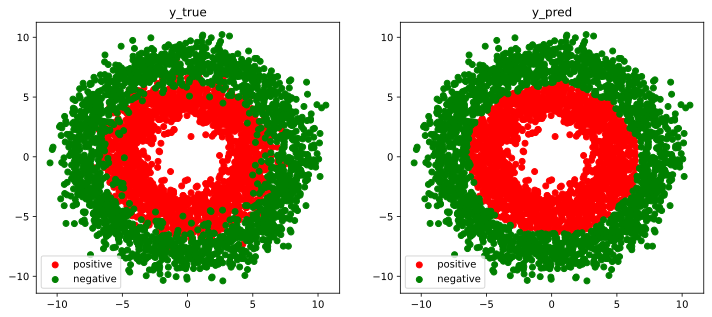

In [31]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");